In [1]:
#! pip install html5lib
#! pip install bs4

In [2]:
# Builtins
from datetime import datetime, date
import requests
import string
import time
import re
import base64
from random import randint

# Bibliotecas Externas
import numpy as np
import pandas as pd
import bs4
import html5lib
from kaggle_secrets import UserSecretsClient


In [3]:
# Importação de Chaves para integração com o Github
user_secrets = UserSecretsClient()
github_access_token = user_secrets.get_secret("github_rent_price_monitoring")

In [4]:
# Classe GithubAPI: Gerencia a integração do notebook com o Github

class GithubApi():
    def __init__(self, token:str, owner:str, repo:str) -> None:
        """
        Inicia a classe GithubApi com o token de autenticação, usuário e repositório.
        
        Args:
        - token: string do token pessoal ou fine-grained.
        - owner: nome de usuário
        - repo: nome do repositório a ser conectado
        
        Retorna:
        Uma instância do objeto GithubApi
        """
        self.token = token
        self.owner = owner
        self.repo = repo
        self.base_url = f'https://api.github.com/repos/{owner}/{repo}'
        
    def get_url(self, file_path:str) -> str:
        """
        Retorna uma url formatada com os parâmetros da api do usuário
        
        Args:
        - file_path: O caminho para o arquivo dentro do repositório
        
        Retorna:
        URL no formato
        ```python
        api.get_url('file.csv')
        # https://api.github/.com/repos/cacau/florianopolis_rent_pricing_monitoring/file.csv
        ```
        """
        return f'{self.base_url}/contents/{file_path}'
        
    def get_file_info(self, file_url) -> str:
        """
        Recupera as informações de armazenamento de um arquivo de um repositório do Github
        
        Args:
        = file_url: url do arquivo obtida com a função get_url.
        
        Retorna:
        download_url: Url direta do conteúdo do arquivo.
        current_sha: chave criptografada com permissão de alterar o arquivo
        file_url: URL de local do arquivo fornecida pelo github
        """
        headers = {'Authorization': f'token {self.token}'}
        response = requests.get(url=file_url, headers=headers)
        response.raise_for_status()
        response_json = response.json()
        download_url = response_json['download_url']
        current_sha = response_json['sha']
        return download_url, current_sha, file_url
    
    def _download_current_content(self, download_url) -> pd.DataFrame:
        """
        Baixa o conteúdo do arquivo a partir da url de download.
        
        O Método self._download_current_content analisa a string da url de download para identificar
        o formato de arquivo e então utiliza um método de extração adequado para o tipo de formato.
        
        No momenro apenas o download de arquivos csv está implementado com a função pd.read_csv.
        
        Args:
        - download_url: url do arquivo obtida com a função get_file_info.
        
        Retorna:
        Dataframe Pandas com os valores do arquivo.
        """
        extension = download_url.split('.')[-1]
        if extension == 'csv':
            return pd.read_csv(download_url,index_col=0)
        elif extension == 'parquet':
            return pd.read_csv
        else:
            raise TypeError(f'file format {extension} is not supported')
                
    def _append_new_content(self,current_content=pd.DataFrame, new_content=pd.DataFrame) -> pd.DataFrame:
        """
        Adiciona o conteúdo do novo result_set ao Dataframe existente.
        
        Kwargs:
        - current_content: Dataframe do dataset atual. 
        - new_content: Dataframe do novo result_set.
        
        Retorna:
        Dataframe Pandas com os valores unidos.
        """
        return pd.concat([current_content,new_content])
    
    def _get_encoded_content(self, appended_content=pd.DataFrame, file_format='csv'):
        """
        Formata o conteúdo do dataframe para inclusão no Github
        
        Kwargs:
        - appended_content: Dataframe com os valores a serem codificados para envio.
        - file_format: O formato para codificação, CSV por padrão.
        
        Retorna:
        Arquivo base64 na codificação desejada.
        """
        if file_format == 'csv':
            csv_data = appended_content.to_csv()
            return base64.b64encode(csv_data.encode()).decode('utf-8')
        else:
            raise TypeError(f'Unsuported file type in _get_encoded_content function')
    
    def _put_content(self, headers, data, url) -> requests.models.Response:
        """
        Realiza requisição PUT com payload formatado.
        
        Kwargs:
        - appended_content: Dataframe com os valores a serem configurados para envio.
        
        Retorna:
        Arquivo base64 na codificação desejada.
        """
        try:
            response = requests.put(url=file_url, headers=headers, json=data)
            response.raise_for_status()
            return response
        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
        except Exception as err:
            print(f'Other error occurred: {err}')
        else:
            if response.status_code == 200:
                print("File updated successfully.")
            else:
                print(f"Failed to update file. Status code: {response.status_code}")
    
    def update_file_content(self, file_path, new_content, method='append') -> None:
        """
        Realiza o update do conteúdo de um arquivo a partir de um path e um novo conteúdo.
        
        Args:
        - file_path: o caminho do arquivo dentro do repositório.
        - new_content: o Dataframe com o conteúdo a ser inserido.
        
        Kwargs:
        - method: 'append' Adiciona o novo conteúdo ao existente | 'overwrite' sobrescreve o conteúdo com o novo.
        """
        file_url = self.get_url(file_path=file_path)
        download_url, current_sha, file_url = self.get_file_info(file_url)
        current_content = self._download_current_content(download_url)
        if method == 'append':
            appended_content = self._append_new_content(current_content, new_content)
        elif method == 'overwrite':
            appended_content = new_content
        else:
            raise TypeError('"method" must be one of "append" or "overwrite".')
        encoded_content = self._get_encoded_content(appended_content)
        commit_message = f"Automatically updated via Kaggle script"
        headers = {'Authorization': f'token {self.token}'}
        data = {"message": commit_message,"content": encoded_content,"sha": current_sha}
        self._put_content(headers=headers, data=data, url=file_url)
        

In [5]:
def extract_address(string):
    formatted_chars = []
    bairro = None
    numero = None
    rua = None
    for char in string:
        if char in "-,/;|.":
            formatted_chars.append(',')
        else:
            formatted_chars.append(char)
    formatted_string = ''.join(formatted_chars)
    term_list = formatted_string.split(',')[::-1]
    try:
        bairro = term_list[2]
    except:
        bairro = None
    try:
        numero = int(''.join(re.findall(r'\d', formatted_string)))
    except:
        numero = None
    try:
        rua = term_list[len(term_list)-1] if len(term_list) > 1 else None
    except:
        rua = None
    return dict(
        bairro = bairro,
        numero = numero,
        rua = rua
    )

In [6]:
class VivaRealApi():
    def __init__(self, cidade:str, delay_seconds=0) -> None:
        self.type = 'Viva Real'
        self.current_page = 1
        self.city = cidade
        self.delay_seconds = delay_seconds
        self._last_http_response = None
        self.result_set = pd.DataFrame(
            {'data': pd.Series(dtype='datetime64[ns]'),
             'fonte': pd.Series(dtype='str'),
             'descricao': pd.Series(dtype='str'),
             'endereco': pd.Series(dtype='str'),
             'rua': pd.Series(dtype='str'),
             'numero': pd.Series(dtype='int'),
             'bairro': pd.Series(dtype='str'),
             'cidade': pd.Series(dtype='str'),
             'valor': pd.Series(dtype='float'),
             'periodicidade': pd.Series(dtype='str'),
             'condominio': pd.Series(dtype='float'),
             'area': pd.Series(dtype='float'),
             'qtd_banheiros': pd.Series(dtype='int'),
             'qtd_quartos': pd.Series(dtype='int'),
             'qtd_vagas': pd.Series(dtype='int'),
             'url': pd.Series(dtype='str')
                  })
        
    @property
    def endpoint(self) -> str:
        return f'https://www.vivareal.com.br/aluguel/santa-catarina/{self.city}/?pagina='
    
    @property
    def _first_page(self) -> bs4.BeautifulSoup:
        response = self._extract_current_page()
        return self._parse_html_response(response=response)
    
    @property
    def _result_count(self) -> int:
        soup = self._first_page
        try:
            return int(soup.find('strong',{'class':'results-summary__count'}).text.replace('.',''))
        except:
            print(f'No houses were found for the given page.\n the HTML structure of the page might have been altered...')
            return 0
        
    @property
    def _results_per_page(self) -> int:
        soup = self._first_page
        listings = self._extract_listings_from_soup(soup=soup)
        return len(listings)
    
    def _get_endpoint(self) -> str:
        seed = randint(1,6)
        
        match seed:
            case 1:
                return f'{self.endpoint}{self.current_page}#onde=Brasil,Santa%20Catarina,Florian%C3%B3polis,,,,,,BR%3ESanta%20Catarina%3ENULL%3EFlorianopolis,,,'
            case 2:
                return f'{self.endpoint}{self.current_page}'
            case 3:
                return f'{self.endpoint}{self.current_page}#onde=Florian%C3%B3polis,,,'
            case 4:
                return f'{self.endpoint}{self.current_page}#onde=Brasil,Santa%20Catarina,Florian%C3%B3polis,,BR%3ESanta%20Catarina%3ENULL%3EFlorianopolis,,,'
            case 5:
                return f'{self.endpoint}{self.current_page}#onde=Brasil,Santa%20Catarina,Florian%C3%B3polis,,,,BR%3ESanta%20Catarina%3ENULL%3EFlorianopolis,,,'
            case 6:
                return f'{self.endpoint}{self.current_page}#onde=,Santa%20Catarina,Florian%C3%B3polis,,,,,,,city,BR%3ESanta%20Catarina%3ENULL%3EFlorianopolis,,,'
    
    def _get_new_page_number(self) -> int:
        return randint(1,round(self._result_count/self._results_per_page))
    
    def _extract_current_page(self, max_retries=5, backoff_factor=2) -> requests.models.Response:
        retries = 0
        while retries < max_retries:
            if self.current_page > 1:
                time.sleep(self.delay_seconds) 
            response = requests.get(self._get_endpoint())
            if response.status_code < 300:  # Successful response
                return response
            elif response.status_code == 429:  # Too many requests
                print(f"Rate limited. Retrying in {backoff_factor ** retries} seconds.")
                time.sleep(backoff_factor ** retries)
                retries += 1
            else:
                print(f"Request failed with status code {response.status_code}")
                return None
            self._last_http_response = response.status_code
    
    def _parse_html_response(self, response=None) -> bs4.BeautifulSoup:
        if response and response.status_code < 300:
            return bs4.BeautifulSoup(response.text, features="html5lib")
        elif response:
            print(f'No valid response to be parsed. Status code {response.status_code}.')
            return None
        else:
            print('Empty request')
        
    def _extract_listings_from_soup(self, soup) -> bs4.element.ResultSet:
        return soup.find_all('article', {'class': 'property-card__container js-property-card'})
    
    def _format_listing(self, listing=None) -> list:
            data = datetime.now()
            fonte = self.type
            cidade = self.city
            formatted = []
            try:
                descricao = listing.find('span', {'class': 'js-card-title'}).text.strip()
            except:
                descricao = None
            try:
                endereco = listing.find('span', {'class': 'property-card__address'}).text.replace('-',',').replace('|','').strip()
            except:
                endereco = ''
            try:
                rua = extract_address(endereco)['rua']
            except:
                rua = None
            try:
                numero = extract_address(endereco)['numero']
            except:
                numero = None   
            try:
                bairro = extract_address(endereco)['bairro']
            except:
                bairro = None
            try:
                valor = listing.find('div', {'class': 'property-card__price'}).text.replace('R$','').replace('.','').split('/')[0]
            except:
                valor = None
            try:
                periodicidade = listing.find('div', {'class': 'property-card__price'}).text.replace('R$','').replace('.','').split('/')[1].split(' ')[0]
            except:
                periodicidade = None
            try:
                condominio = listing.find('strong', {'class': 'js-condo-price'}).text.replace('R$','').strip()
            except:
                condominio = None
            try:
                area = listing.find('span', {'class': 'js-property-card-detail-area'}).text.strip()
            except:
                area = None
            try:
                qtd_banheiros = listing.find('li', {'class': 'property-card__detail-bathroom'}).text.strip()[0]
                qtd_banheiros = int(''.join(re.findall(r'\d', qtd_banheiros)))
            except:
                qtd_banheiros = None
            try:
                qtd_quartos = listing.find('li', {'class': 'property-card__detail-room'}).text.strip()[0]
                qtd_quartos = int(''.join(re.findall(r'\d', qtd_quartos)))
            except:
                qtd_quartos = None
            try:
                qtd_vagas = listing.find('li', {'class': 'property-card__detail-garage'}).text.strip()[0]
                qtd_vagas = int(''.join(re.findall(r'\d', qtd_vagas)))
            except:
                qtd_vagas = None
            try:
                link = 'https://vivareal.com.br' + listing.find('a', {'class': 'property-card__labels-container'})['href']
            except:
                link = None
            return [data,fonte,descricao,endereco,rua,numero,bairro,cidade,valor,periodicidade,condominio,area,qtd_banheiros,qtd_quartos,qtd_vagas,link]
    
    def _append_formatted_listing(self, listing=None) -> None:
        try:
            if not listing[-1] in self.result_set['url'].to_list():
                self.result_set.loc[self.result_set.shape[0]] = listing
                return True
        except:
            print(f'Error appending the following listing:\n{listing}')
            return False
        else:
            return False
    
    def _ingest_current_page(self) -> None:
        try:
            print(f'Current_page: {self.current_page}')
            response = self._extract_current_page()
            soup = self._parse_html_response(response=response)
            listings = self._extract_listings_from_soup(soup=soup)
            added_listings = 0
            for i in listings:
                formatted = self._format_listing(listing = i)
                success = self._append_formatted_listing(listing=formatted)
                if success == True:
                    added_listings += 1
        except exception:
            print(f'Something went wrong while formating the listings of the page {self.current_page}: {exception}')
        else:
            print(f'{added_listings} novos anúncios adicionados na página {self.current_page}')
            self.current_page = self._get_new_page_number()
    
    def ingest_listings(self, all=True, max_attempts=None) -> None:
        attempts = 0
        if all == True:
            while self.result_set.shape[0] < self._result_count:
                    self._ingest_current_page()
                    attempts += 1
        elif max_attempts:
            if type(max_attempts) == int and max_attempts > 0:
                self.current_page = 1
                while attempts <= max_attempts:
                    self._ingest_current_page()
                    attempts += 1
            else:
                raise TypeError('pages_number: This parameter only accepts numbers above zero.')
                
    def dump_result_set(self, path=None, format='csv') -> None:
        if format=='csv':
            self.result_set.to_csv(f'{path}{self.city}_{date.today()}.csv')
        elif format=='parquet':
            self.result_set.to_parquet(f'{path}{self.city}_{date.today()}.parquet')
        else:
            print(f'Option not allowed: {format}')

In [7]:
api = VivaRealApi('florianopolis',delay_seconds=2)
api.ingest_listings(all=False, max_attempts=200)


Current_page: 1
36 novos anúncios adicionados na página 1
Current_page: 102
0 novos anúncios adicionados na página 102
Current_page: 21
0 novos anúncios adicionados na página 21
Current_page: 19
0 novos anúncios adicionados na página 19
Current_page: 39
0 novos anúncios adicionados na página 39
Current_page: 81
0 novos anúncios adicionados na página 81
Current_page: 120
0 novos anúncios adicionados na página 120
Current_page: 75
0 novos anúncios adicionados na página 75
Current_page: 103
0 novos anúncios adicionados na página 103
Current_page: 15
0 novos anúncios adicionados na página 15
Current_page: 195
0 novos anúncios adicionados na página 195
Current_page: 10
0 novos anúncios adicionados na página 10
Current_page: 21
0 novos anúncios adicionados na página 21
Current_page: 121
0 novos anúncios adicionados na página 121
Current_page: 154
0 novos anúncios adicionados na página 154
Current_page: 18
0 novos anúncios adicionados na página 18
Current_page: 200
0 novos anúncios adicionado

<Axes: xlabel='area', ylabel='valor'>

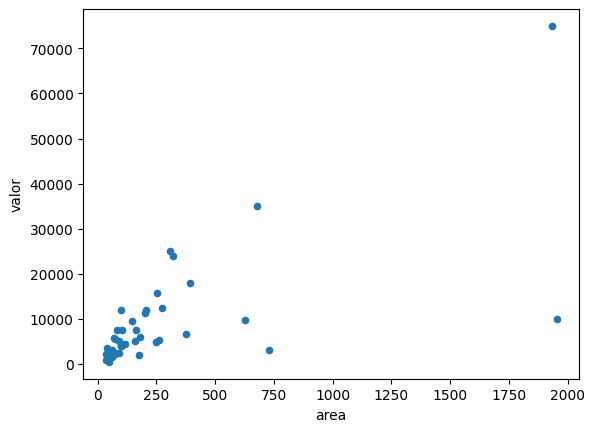

In [8]:
df = api.result_set
df['area'] = df['area'].astype('float')
df['valor'] = df[['valor']].astype('float')
df.plot(kind='scatter',x='area',y='valor')

In [9]:
git = GithubApi(
    token=github_access_token,
    owner='strangercacaus',
    repo='florianopolis_rent_pricing_monitoring')

In [10]:
#file_path = 'dataset.csv'
#new_content = api.result_set
#method = 'overwrite'
#git.update_file_content(file_path, new_content, method='overwrite')